<img src='https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/tools/frameworks/-/raw/main/img/OSI-SAF_banner.png' align='right' width='100%'/>

<a href="../Index.ipynb" target="_blank"><< Index</a>
<br>
<a href="./1_2_OSI_SAF_wind_file_structure.ipynb" target="_blank"><< Exploring OSI SAF wind product structure</a>

<font color="#138D75">**EUMETSAT OSI SAF Training Service**</font> <br>
**Copyright:** 2024 EUMETSAT <br>
**License:** MIT

<html>
  <div style="width:100%">
    <div style="float:left"><a href="https://mybinder.org/v2/git/https%3A%2F%2Fgitlab.eumetsat.int%2Feumetlab%2Foceans%2Focean-training%2Fsensors%2Flearn-osi-saf-wind/HEAD?urlpath=%2Ftree%2F1_OSI_SAF_wind_introductory%2F1_3_OSI_SAF_mapping_wind.ipynb"><img src="https://mybinder.org/badge_logo.svg" alt="Open in Binder"></a></div>
    <div style="float:left"><p>&emsp;</p></div>
  </div>
</html>

<div class="alert alert-block alert-success">
<h3>Learn OSI SAF wind: Introductory</h3></div>

# 2.1b Advanced Mapping : Case study of hurricane Kirk

### Data used

| Product Description | Product Navigator | OSI SAF website link | OSI SAF Identifier |
|:--------------------:|:-----------------------:|:-------------:|:-----------------:|
| HY-2D 25 km wind vectors |  | <a href="https://osi-saf.eumetsat.int/products/osi-116-a" target="_blank">link</a> | OSI-116-a | 

### Learning outcomes

At the end of this notebook you will know;
* Map winds products using cartopy
* Retrive an satellite image from eumetview
* Overlay IR image and wind vector

<div class="alert alert-info" role="alert">
    
## <a id='TOC-TOP'></a>Contents

</div>
    
 1. [Setting Parameters](#section1)
 1. [Mapping a wind dataset with cartopy](#section2)

<hr>

We begin by importing all of the libraries that we need to run this notebook. If you have built your python using the environment file provided in this repository, then you should have everything you need. For more information on building environment, please see the repository **<a href="../README.md" target="_blank">README</a>**.

In [8]:
# library imports
import os                          # a library that allows us access to basic operating system commands
import xarray as xr                # a library that supports the use of multi-dimensional arrays in Python
import matplotlib as mpl           # a library for visualization
import matplotlib.pyplot as plt    # a library that supports plotting
import matplotlib.cm as mpl_cm     # a part of the plotting library that provides colour maps
import cartopy.crs as ccrs         # a mapping library that supports reprojection
import cartopy.feature as cfeature # a part of the mapping library that provides features such as coastlines
import cmocean                     # colormaps for ocean products
import numpy as np                 # a library that supports array manipulation
import warnings                    # a library that controls python warnings
import json                        # a library that allow us to work with json data
import requests                    # a library that allow us to work with HTTP
import eumdac                      # a tool that helps us download via the eumetsat/data-store
import urllib.request              # a library that allow us to work with URL
from pathlib import Path           # a library that helps construct system path objects
from owslib.wms import WebMapService 
from owslib.util import Authentication

#from authorisation_functions import authorisation_functions as auth
warnings.filterwarnings('ignore')


<div class="alert alert-info" role="alert">

## <a id='section1'></a>1. Setting login information
[Back to top](#TOC-TOP)

</div>
The access to eumetview data follows the same process as the access to eumetsat data store.

See the processus at <a href="./1_1b_OSI_SAF_SST_wind_data_access_eumdac.ipynb" target="_blank"> 1_1b_OSI_SAF_SST_wind_data_access_eumdac</a>.

In [10]:
# load credentials
credentials_file = os.path.join(os.path.expanduser("~"),'.eumdac','credentials')
credentials = Path(credentials_file).read_text().split(',')
token = eumdac.AccessToken((credentials[0], credentials[1]))
print(f"This token '{token}' expires {token.expiration}")

# create data store object
datastore = eumdac.DataStore(token)

This token '5c5eee11-8920-3c33-af1f-7a40a11874b1' expires 2025-06-12 21:33:36.397635


<div class="alert alert-info" role="alert">

## <a id='section2'></a>2. Setting Parameters
[Back to top](#TOC-TOP)

</div>

We will work on Hurricane <a href="https://en.wikipedia.org/wiki/Hurricane_Kirk_(2024)">Kirk</a>, and plot the ASCAT wind retrieval of Metop-B satellite on it's descending passage over the hurricane (in the morning) <BR>
The satellite passed over the hurricane on the 04/10/2024 at 11:42UTC. Knowing that, we here pre-downloaded the relevent ASCAT granule (3minutes of wind retrieval). Let's select the direcory where the data of ASCAT 12.5 km wind is available:


In [13]:
directory = os.path.join(os.getcwd(), 'hurricane')

We need not to specify the date and time of the retrieval.

In [15]:
Year, Month, Day, Hour, Minute = 2024, 10, 4, 11, 42

Month_str = "{:02d}".format(Month)
Day_str = "{:02d}".format(Day)
Hour_str = "{:02d}".format(Hour)
Minute_str = "{:02d}".format(Minute)

And finaly, let's select the area we want to map.

In [17]:
# Set area
lon_min = -57
lon_max = -40
lat_min = 16
lat_max = 29

Choose a colormap for your data set. You can find more information on matplotlib colormaps <a href="https://matplotlib.org/stable/tutorials/colors/colormaps.html" target="_blank">here</a>. 

In [19]:
cmap = mpl_cm.get_cmap('RdYlBu_r')

We also recommend you have a look at <a href=" https://matplotlib.org/cmocean/" target="_blank">cmocean colormaps</a> .

In [21]:
# another choice could be
#cmap = cmocean.cm.speed


<div class="alert alert-info" role="alert">

## <a id='section3'></a>2. Background : IR image 
[Back to top](#TOC-TOP)

</div>
The objective of this section is to retrive a Infrared image of the typhon [NOM] from the Eumetsat tool *Emetview*.

In an infrared image, clouds can be visualize and so, it is possible to see the wrap-around cloud of the hurricane.

Set the url link of eumetview

In [24]:
service_url = 'https://view.eumetsat.int/geoserver/ows?'

Set the image collection <BR>
We are going to use here the Eumetsat Geostationary Ring IR10.8 Image product, a <b>3-hourly aggregate</b> imagery of the 10.8 infrared channels from the satellites on position at GOES-West, GOES-East, Meteosat 0 Degree, Meteosat Indian Ocean and Himawari. This product is a Level-3 product, that gives a full coverage of the globe from 60°N to 60°S every 3 hours.

In [26]:
collection = "mumi:worldcloudmap_ir108"

We could as well use the L1 IR10.8 data from Meteosat-0° (Meteosat-10 at the time, a second generation satellite). This product is a Level-1 product : it is a top of the atmosphere retrieval by a single channel of one satellite, with maximum spatial resolution (3.1km at the satellite nadir), and a temporal resolution of <b>15min</b>.<br><br>
<b>But let's do it in a second time.</b>

In [28]:
#collection = "msg_fes:ir108"

Let's set the geographical area and date parameter we want an IR image for.

In [30]:
region1 = str(lat_min) + "," + str(lon_min) + "," + str(lat_max) + "," + str(lon_max)

print("region1 = "+ region1)

# date in ISO format
date = str(Year) +"-"+Month_str+"-"+Day_str+"T"+Hour_str+":"+Minute_str+":00.000Z"

print("date (ISO format) = "+date)


region1 = 16,-57,29,-40
date (ISO format) = 2024-10-04T11:42:00.000Z


Research the image

In [32]:
wms = WebMapService(service_url, auth=Authentication(verify=False))

# set the size of the image
xval = 800
region = [int(x) for x in region1.split(",")]
ratio = (region[3] - region[1])/ (region[2] - region[0])

format_option = 'image/jpeg'
payload = {'service' : 'WMS',
'access_token' : token,
'request' : 'GetMap',
'version' : '1.3.0',
'layers' : collection + ",backgrounds:ne_10m_coastline", # We display the layer together with the coastlines layer
'format' : format_option,
'crs' : 'EPSG:4326',
'bbox' : region1,
'width' : int(xval),  
'height' : int(xval/ratio), 
'time': date }   
req = requests.get(service_url, params=payload)

Plot the IR image 

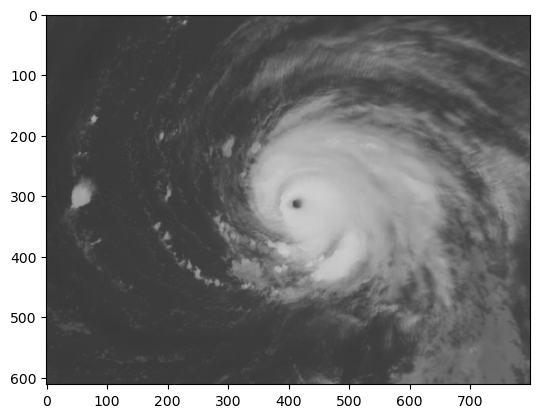

In [34]:
file = urllib.request.urlopen(req.url)
im_IR = plt.imread(file, 0)
plt.imshow(im_IR)

<div class="alert alert-info" role="alert">

## <a id='section3'></a>3. Wind vector
[Back to top](#TOC-TOP)

</div>
The objective of this section is to plot the wind vectors of the hurricane Kirk.

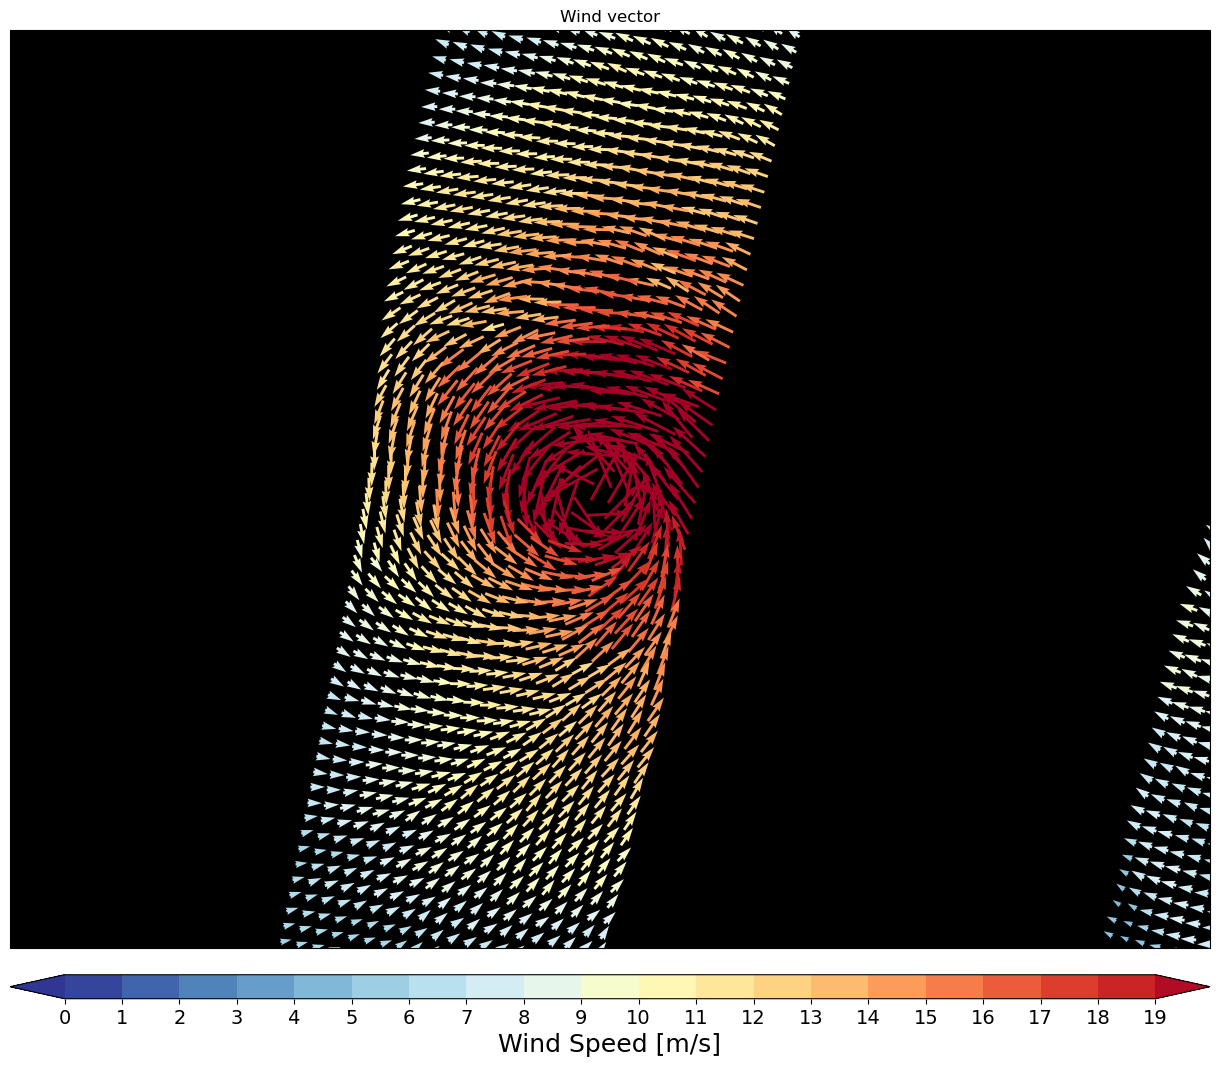

In [36]:
fig = plt.figure(figsize=(16,12))

# set data projection and request output projection
data_projection=ccrs.PlateCarree()
output_projection=ccrs.PlateCarree()

# define plot carateristics
ax = plt.axes([0.1,0.1,0.75,0.85], projection=output_projection)
ax.set_extent([lon_min,lon_max,lat_min,lat_max], crs=data_projection)
ax.add_feature(cfeature.OCEAN, zorder=0, facecolor='black') # Change color of ocean
ax.add_feature(cfeature.LAND, zorder=0, facecolor='lightgrey')  # Change color of landl 
ax.coastlines()    # Add coastline
ax.coastlines('10m')
#Add title
plt.title("Wind vector")

# open and plot osi saf netcdf wind files
for filename in os.listdir(directory):
    if filename.endswith(".nc"):
        nc = xr.open_dataset(os.path.join(directory, filename),decode_times=False)
        lat = nc.variables['lat'][:]    
        lon = nc.variables['lon'][:]
        wind_speed = nc.variables['wind_speed'][:]
        wind_dir = nc.variables['wind_dir'][:]
        nc.close()
        
        wind_speed = np.ma.masked_where(lon<1, wind_speed)
        
        # plotting wind barbs in cartopy requires u and v and components.
        u = np.full_like(lat,0)
        v = np.full_like(lat,0)
        u[:,:] = wind_speed * np.cos(np.radians(90 - wind_dir[:,:]))
        v[:,:] = wind_speed * np.sin(np.radians(90 - wind_dir[:,:]))
        stride = 2  #Select some data
        
        # plotting wind direction and wind speed
        im = ax.quiver(lon[::stride,::stride], lat[::stride,::stride], u[::stride,::stride], 
                v[::stride,::stride], wind_speed[::stride,::stride], cmap=cmap, transform=data_projection, 
                scale = 600)
        
        im.set_clim(0,20)
        
# Adding a colorbar
axc = fig.add_axes((0.1,0.10,0.75,0.02))
bounds = range(0,20)
cb = plt.colorbar(im, orientation='horizontal', extend='both', cax=axc, ticks=bounds, boundaries=bounds)
cb.set_label('Wind Speed [m/s]', fontsize=18)
cb.ax.tick_params(labelsize=14)

##
<div class="alert alert-info" role="alert">

## <a id='section4'></a>4. Overlay
[Back to top](#TOC-TOP)

</div>
The obejctive of this final section is to overlay the IR image with the wind vetor.

In [38]:
fig = plt.figure(figsize=(16,12))

# set data projection and request output projection
data_projection=ccrs.PlateCarree()
output_projection=ccrs.PlateCarree()

<Figure size 1600x1200 with 0 Axes>

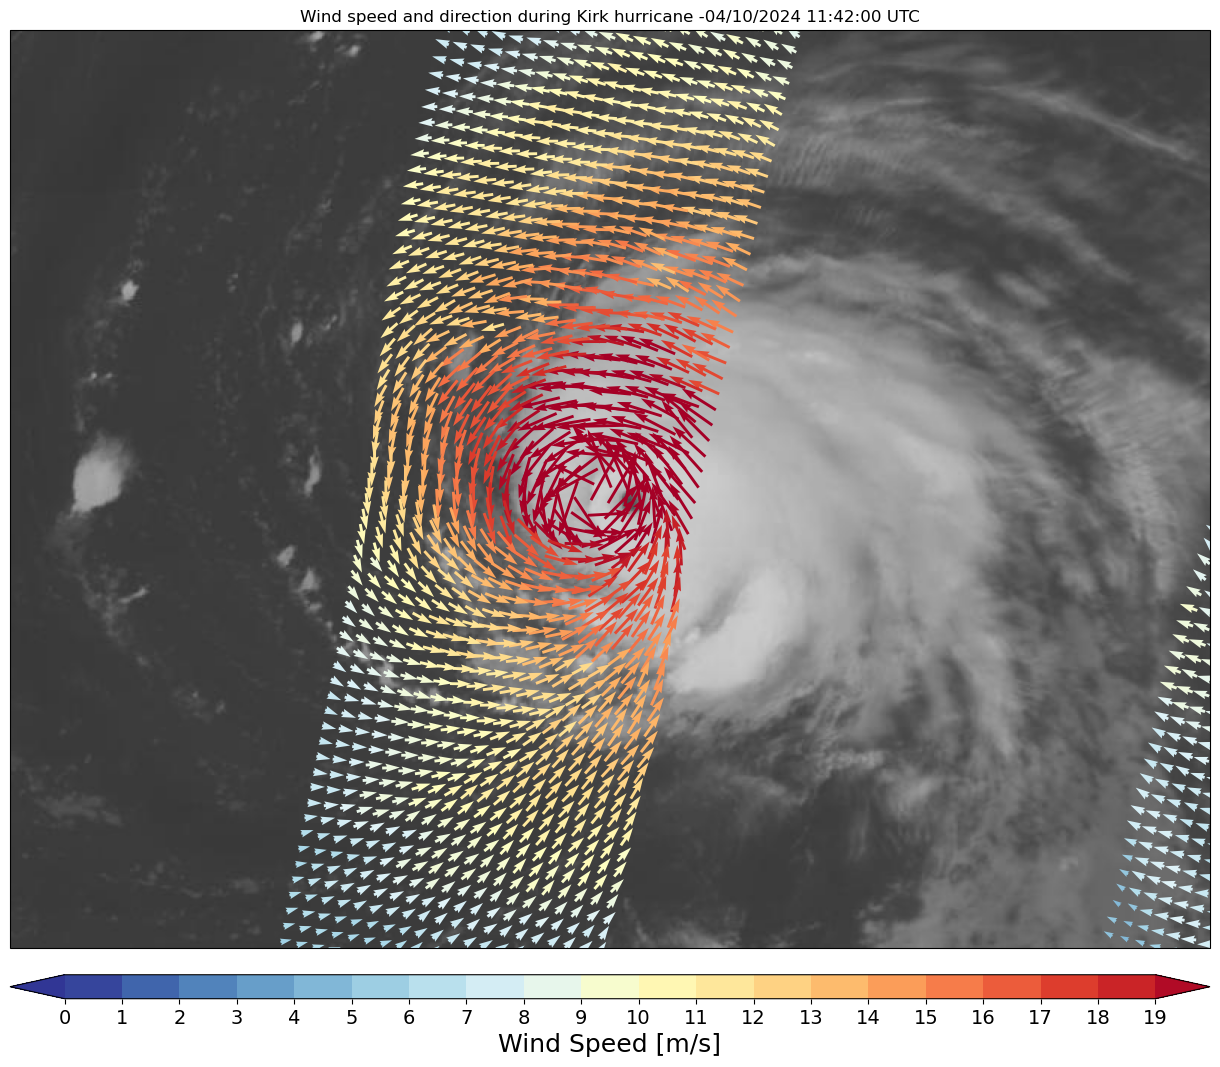

In [39]:
fig = plt.figure(figsize=(16,12))

# set data projection and request output projection
data_projection=ccrs.PlateCarree()
output_projection=ccrs.PlateCarree()

# define plot carateristics
ax = plt.axes([0.1,0.1,0.75,0.85], projection=output_projection)
ax.set_extent([lon_min,lon_max,lat_min,lat_max], crs=data_projection)
ax.add_feature(cfeature.OCEAN, zorder=0, facecolor='black') # Change color of ocean
ax.add_feature(cfeature.LAND, zorder=0, facecolor='lightgrey')  # Change color of land
ax.coastlines()    # Add coastline
ax.coastlines('10m')

#Add title
plt.title("Wind speed and direction during Kirk hurricane -" + Day_str + "/" + Month_str + "/" + str(Year) + " " + Hour_str +":"+Minute_str+":00 UTC" )

#Add IR backgroud image
img_extent = (lon_min, lon_max, lat_min, lat_max)
ax.imshow(im_IR, origin='upper', extent=img_extent, transform=ccrs.PlateCarree())

# open and plot osi saf netcdf wind files
for filename in os.listdir(directory):
    if filename.endswith(".nc"):
        nc = xr.open_dataset(os.path.join(directory, filename), decode_times=False)
        lat = nc.variables['lat'][:]    
        lon = nc.variables['lon'][:]
        wind_speed = nc.variables['wind_speed'][:]
        wind_dir = nc.variables['wind_dir'][:]
        nc.close()
        
        wind_speed = np.ma.masked_where(lon<1, wind_speed)
        
        # plotting wind barbs in cartopy requires u and v and components.
        u = np.full_like(lat,0)
        v = np.full_like(lat,0)
        u[:,:] = wind_speed * np.cos(np.radians(90 - wind_dir[:,:]))
        v[:,:] = wind_speed * np.sin(np.radians(90 - wind_dir[:,:]))
        stride = 2  #Select some data
        
        # plotting wind direction and wind speed
        im = ax.quiver(lon[::stride,::stride], lat[::stride,::stride], u[::stride,::stride], 
                v[::stride,::stride], wind_speed[::stride,::stride], cmap=cmap, transform=data_projection, 
                scale = 600)

        im.set_clim(0,20)        
# Adding a colorbar
axc = fig.add_axes((0.1,0.10,0.75,0.02))
bounds = range(0,20)
cb = plt.colorbar(im, orientation='horizontal', extend='both', cax=axc, ticks=bounds, boundaries=bounds)
cb.set_label('Wind Speed [m/s]', fontsize=18)
cb.ax.tick_params(labelsize=14)

When overlaying our Metop-B / ASCAT wind vector with our L3 mutli-satellite IR10.8 image, we can observe a gap between the two type of data. This gap is here due to the delay between the time the L3 IR data was aggregate, and the time of passing over by Metop-B. The nearest L3 IR available, wich is product every 3h, doesn't fully correspond to the Metop-B passing time over Kirk. If we want to have a better time correspondance, we should use the L1 data from a single satellite. Kirk area was covered at the time by Meteosat-10 at 0°. Let's go back to [chapter 2](#section3) to select another IR image, and replot our overlay.

<hr>
<a href="../Index.ipynb" target="_blank"><< Index</a>
<br>
<a href="./1_2_OSI_SAF_wind_file_structure.ipynb" target="_blank"><< Exploring OSI SAF wind product structure</a>
<hr>
<a href="https://gitlab.eumetsat.int/eumetlab/ocean">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a> | <a href=mailto:ops@eumetsat.int>Contact helpdesk for support </a> | <a href=mailto:training@eumetsat.int>Contact our training team to collaborate on and reuse this material</a></span></p>